In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import colormaps as cmaps
from readCMIP5 import readCMIP5Data

%pylab inline

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-warning">
<h3>Let's read in our data files for surface air temperature (TAS). We focus on using a consistent ensemble (#1) from CCSM4, but for varying representative concentration pathway (RCP) scenarios. These scenarios allow us to evaluate the different forcings from anthropogenic climate change.</h3>
</div>

In [9]:
snow_depth =  xr.open_dataset('../data/SnowDepth_snd/snd_grid50N_CCSM4_rcp45_1.nc', decode_times=False)
snow_depth = readCMIP5Data("../data/SnowDepth_snd/", "gridded", "rcp45", "1", "snd")

ValueError: total size of new array must be unchanged

In [14]:
readCMIP5Data("../data/SurfaceAirTemperature_tas/",'gridded','historical','1','tas')

(array([ 65.4973822 ,  66.43979058,  67.38219895,  68.32460733,
         69.26701571,  70.20942408,  71.15183246,  72.09424084,
         73.03664921,  73.97905759,  74.92146597,  75.86387435,
         76.80628272,  77.7486911 ,  78.69109948,  79.63350785,
         80.57591623,  81.51832461,  82.46073298,  83.40314136,
         84.34554974,  85.28795812,  86.23036649,  87.17277487,
         88.11518325,  89.05759162,  90.        ]),
 array([   0.  ,    1.25,    2.5 ,    3.75,    5.  ,    6.25,    7.5 ,
           8.75,   10.  ,   11.25,   12.5 ,   13.75,   15.  ,   16.25,
          17.5 ,   18.75,   20.  ,   21.25,   22.5 ,   23.75,   25.  ,
          26.25,   27.5 ,   28.75,   30.  ,   31.25,   32.5 ,   33.75,
          35.  ,   36.25,   37.5 ,   38.75,   40.  ,   41.25,   42.5 ,
          43.75,   45.  ,   46.25,   47.5 ,   48.75,   50.  ,   51.25,
          52.5 ,   53.75,   55.  ,   56.25,   57.5 ,   58.75,   60.  ,
          61.25,   62.5 ,   63.75,   65.  ,   66.25,   67.5 ,   68.

In [59]:
surface_temp =  xr.open_dataset('../data/SeaSurfaceTemperature_tos/tos_grid50N_CCSM4_rcp45_1.nc', decode_times=False)

In [60]:
snow_depth.time

<xarray.DataArray 'time' (time: 1140)>
array([ 732205.5,  732235. ,  732264.5, ...,  766788.5,  766819. ,
        766849.5])
Coordinates:
  * time     (time) float64 7.322e+05 7.322e+05 7.323e+05 7.323e+05 ...
Attributes:
    standard_name: time
    long_name: time
    bounds: time_bnds
    units: days since 0-01-01 00:00:00
    calendar: 365_day

In [61]:
both = snow_depth.update(surface_temp)

In [62]:
both.time

<xarray.DataArray 'time' (time: 1140)>
array([ 732205.5,  732235. ,  732264.5, ...,  766788.5,  766819. ,
        766849.5])
Coordinates:
  * time     (time) float64 7.322e+05 7.322e+05 7.323e+05 7.323e+05 ...
Attributes:
    standard_name: time
    long_name: time
    bounds: time_bnds
    units: days since 0-01-01 00:00:00
    calendar: 365_day

In [63]:
both = both.drop(["nb2", "nv4"])

In [64]:
first_year = both.isel(time=range(30*12))

In [65]:
both_avg = both.mean(dim=["x", "y"])

In [66]:
both_avg_df = both_avg.to_dataframe()

In [67]:
month_idx = pd.date_range('2005-01-01', periods=95*12, freq='1M')
both_avg_df = both_avg_df.set_index(month_idx)

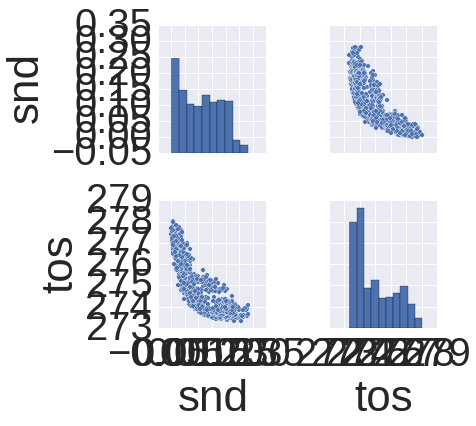

In [68]:
sns.pairplot(both_avg_df)

In [69]:
both_avg_df.corr()

,snd,tos
snd,1.000000,-0.838607
tos,-0.838607,1.000000


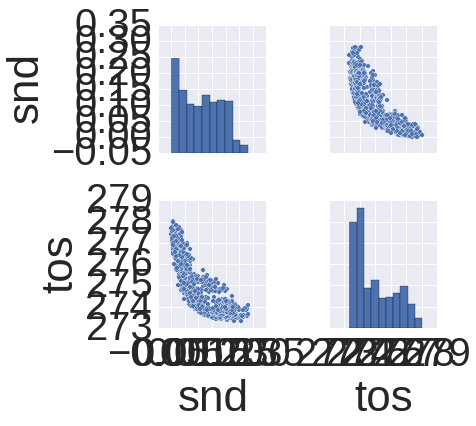

In [70]:
sns.pairplot(both_avg_df)

In [71]:
both_avg_df.index.month

array([ 1,  2,  3, ..., 10, 11, 12], dtype=int32)

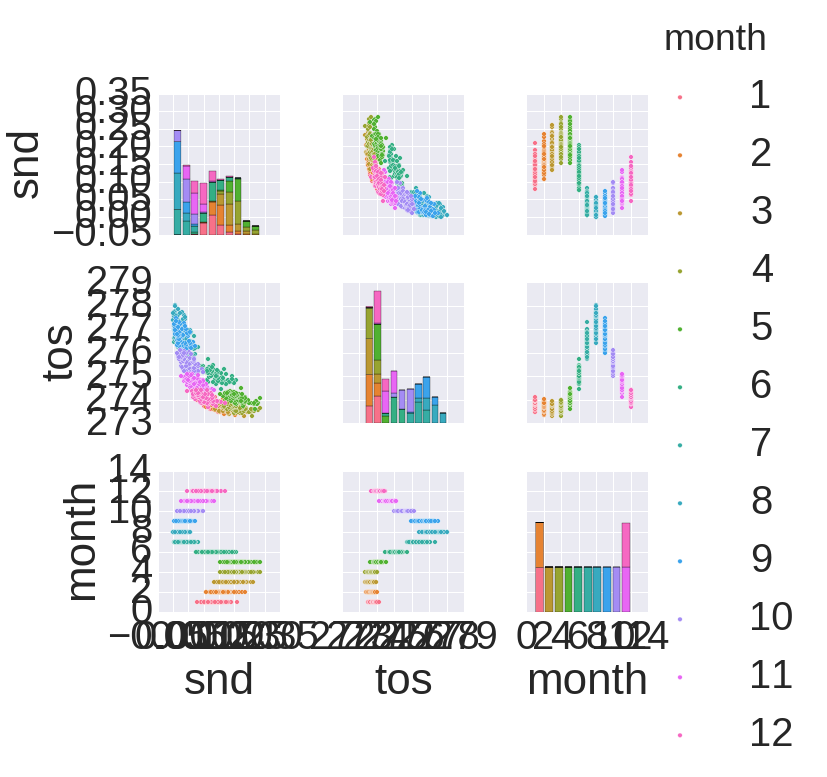

In [72]:
both_avg_df["month"] = both_avg_df.index.month
sns.pairplot(both_avg_df, hue="month")

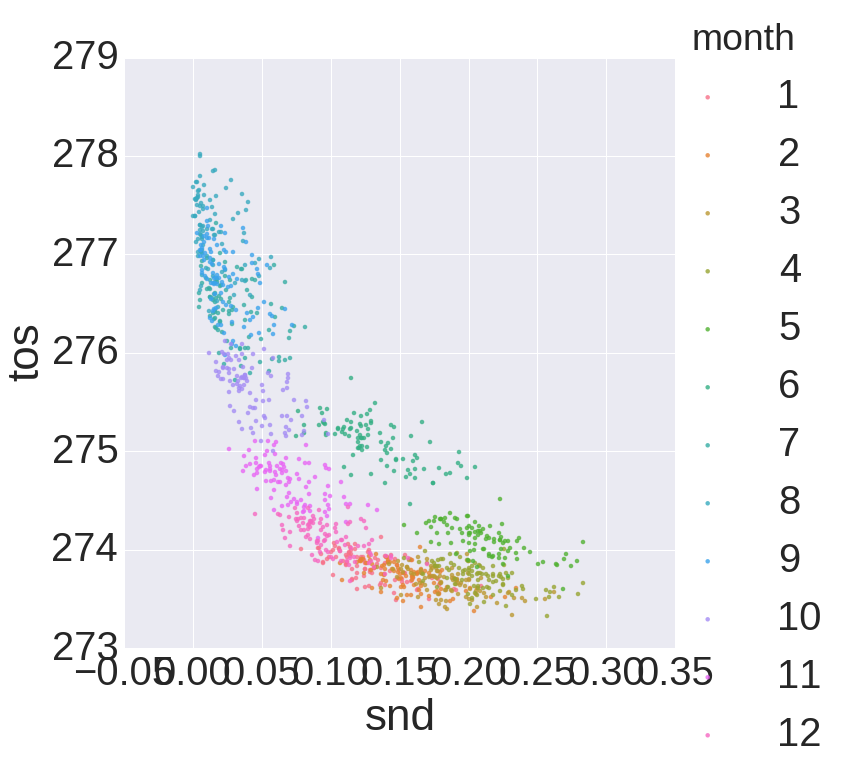

In [73]:
sns.lmplot(x="snd", y="tos", data=both_avg_df, size=10, hue="month", fit_reg=False)

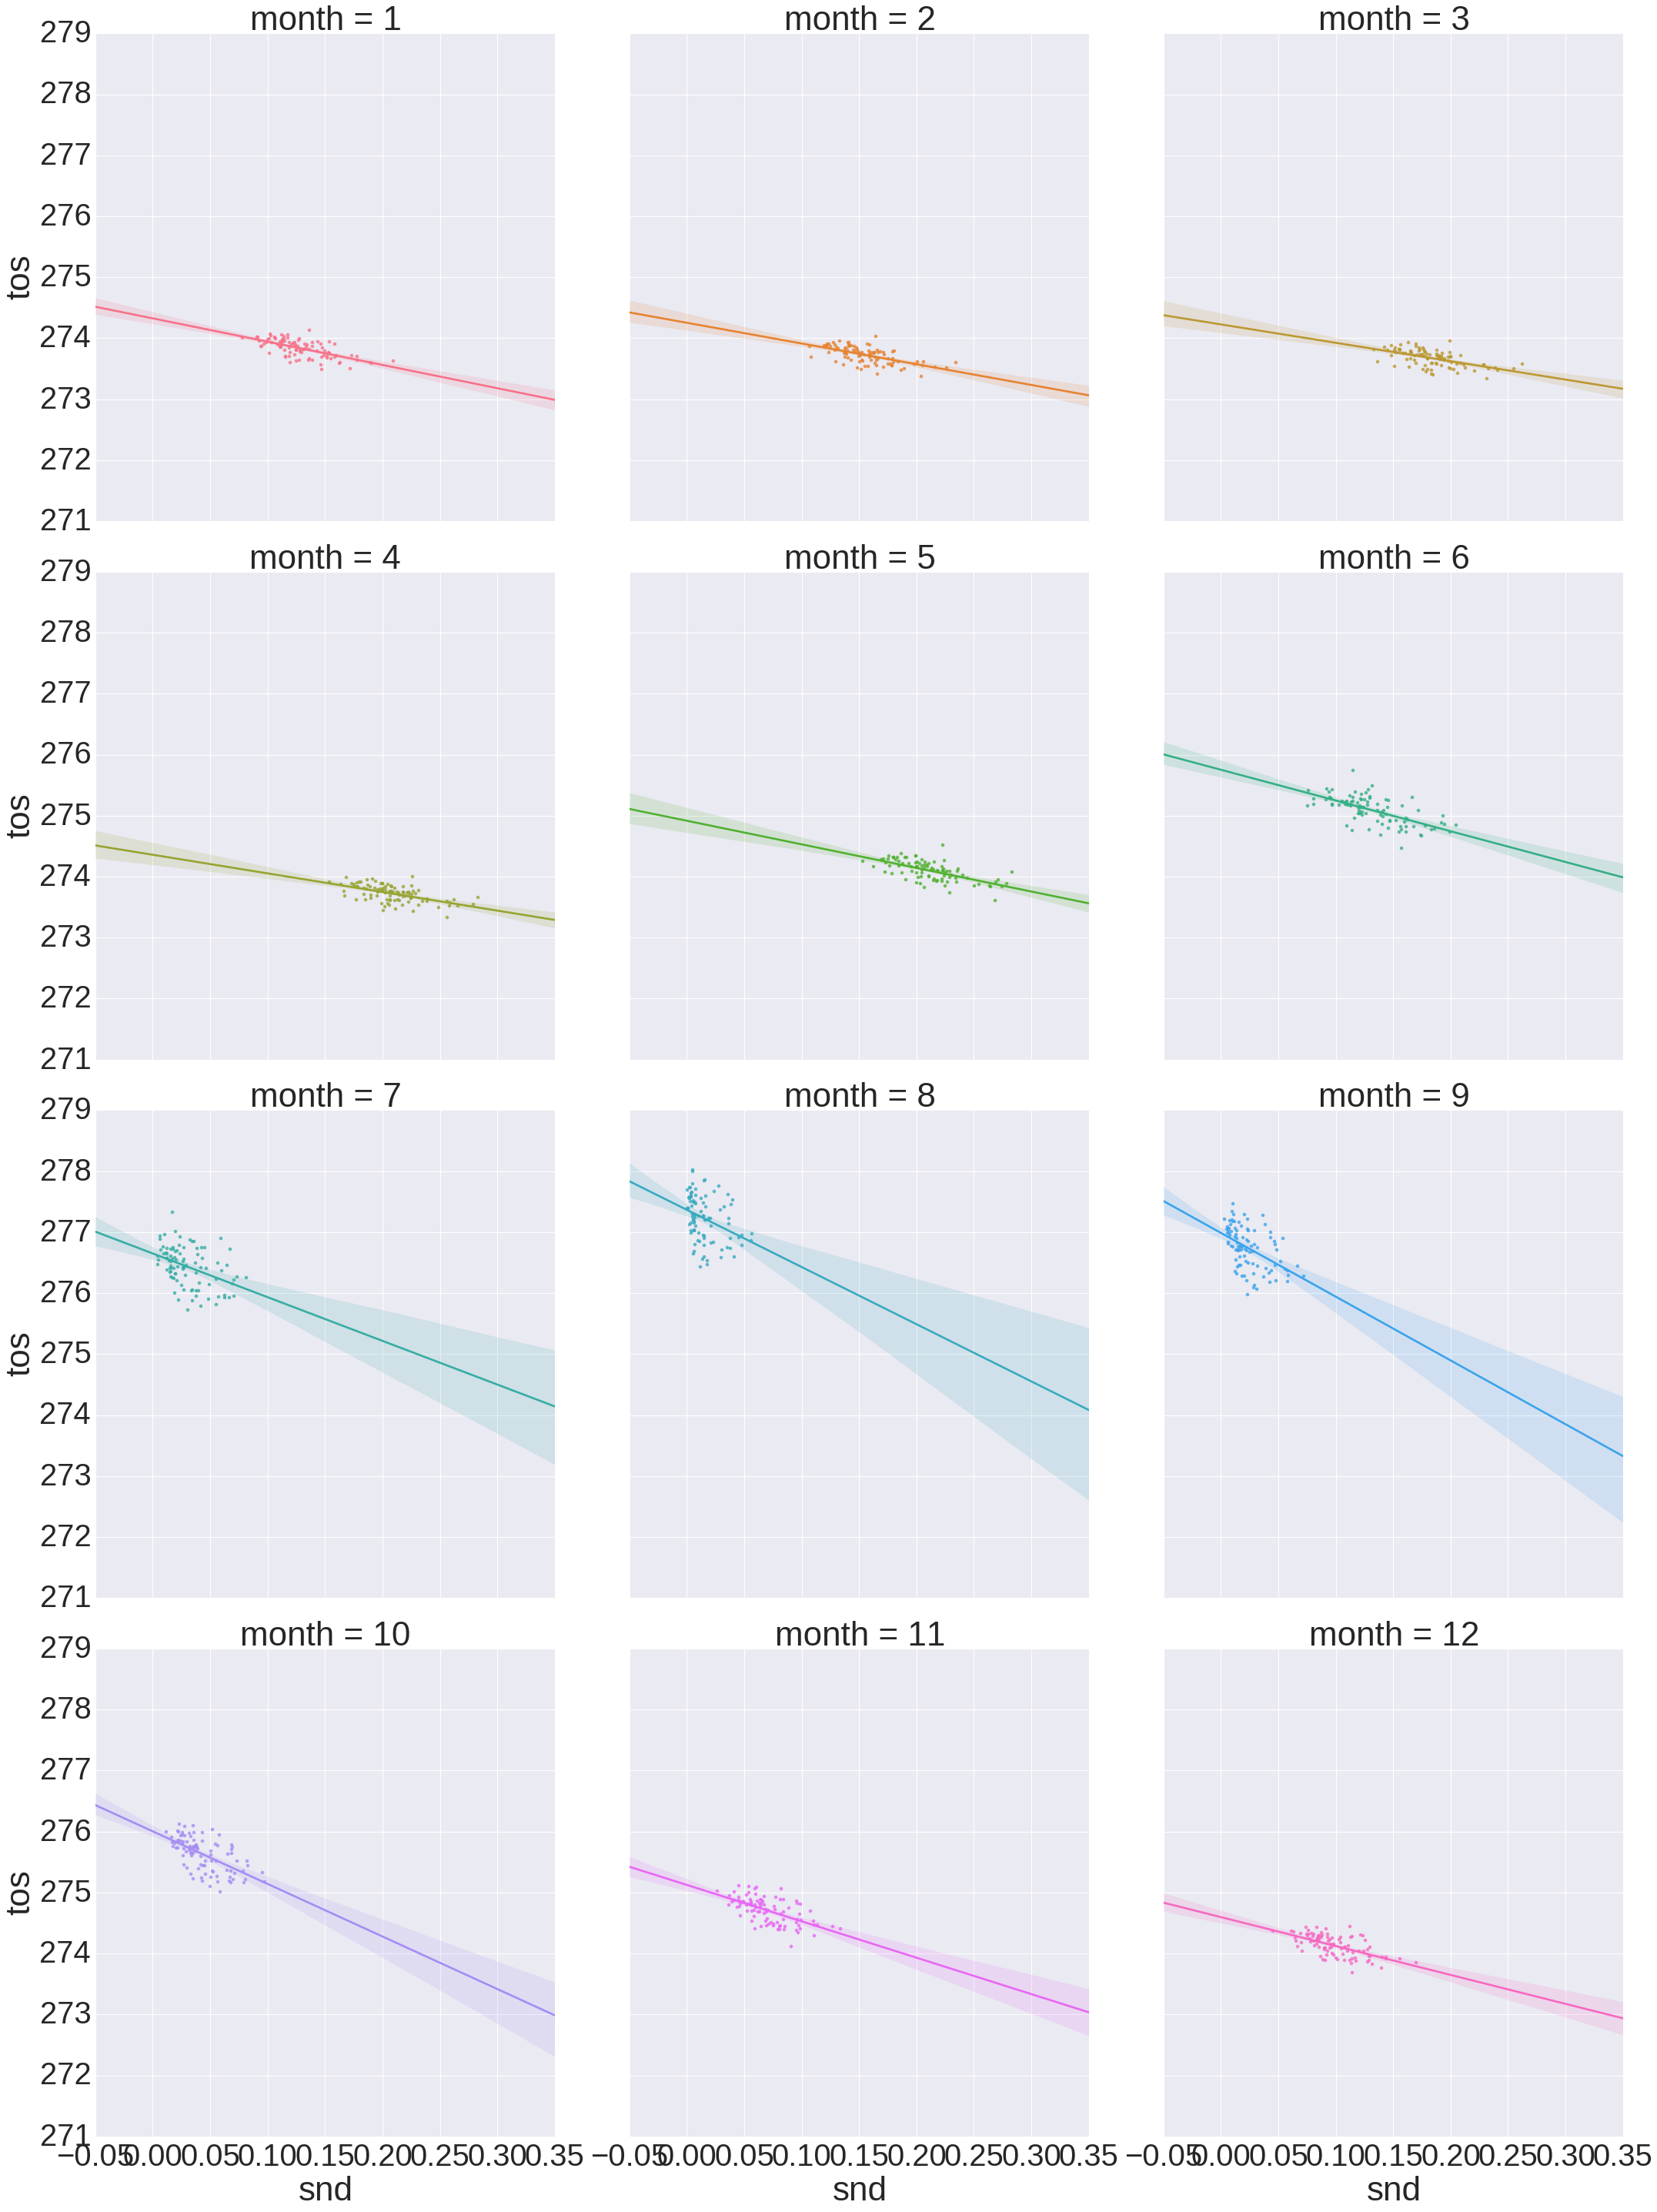

In [74]:
sns.set(font_scale=4)  # crazy big
sns.lmplot(x="snd", y="tos", data=both_avg_df, size=10, col="month", hue="month", col_wrap=3)

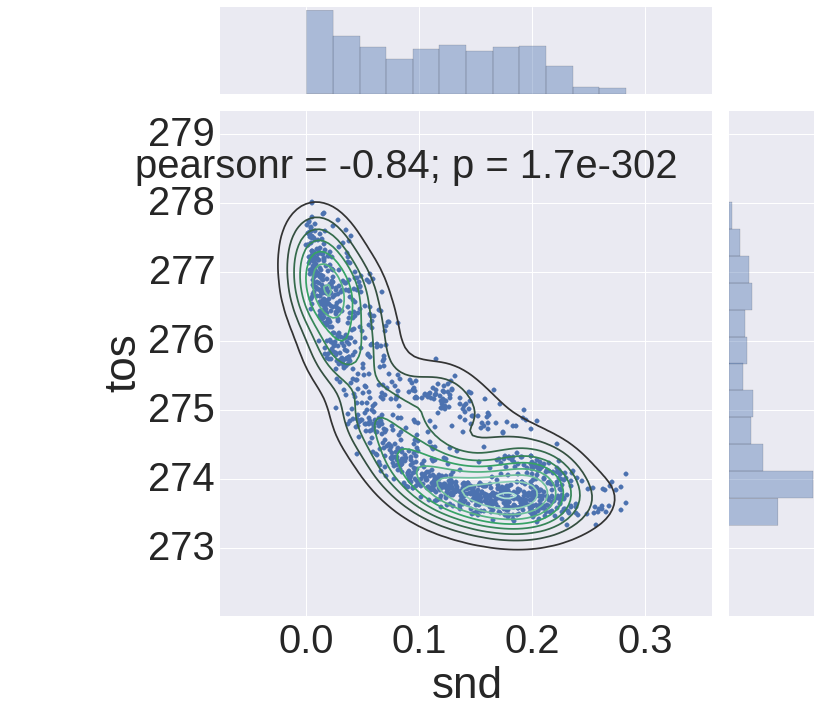

In [75]:
sns.jointplot(x="snd", y="tos", data=both_avg_df, size=10).plot_joint(sns.kdeplot)